- pytorch exercise

# 基本设置

In [37]:
import pandas as pd
import numpy as np

import time

In [38]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

import visdom
# vis = visdom.Visdom()

# load data

## dataset
- Dataset是一个包装类，用来将数据包装为Dataset类，然后传入DataLoader中，我们再使用DataLoader这个类来更加快捷的对数据进行操作。
- DataLoader是一个比较重要的类，它为我们提供的常用操作有：batch_size(每个batch的大小), shuffle(是否进行shuffle操作), num_workers(加载数据的时候使用几个子进程)

> - torch.utils.data.Dataset 
> - torch.utils.data.DataLoader

In [ ]:
class DealDataset(Dataset):
    """
        下载数据、初始化数据，都可以在这里完成
    """
    def __init__(self):
        xy = np.loadtxt('../dataSet/diabetes.csv.gz', delimiter=',', dtype=np.float32) # 使用numpy读取数据
        self.x_data = torch.from_numpy(xy[:, 0:-1])
        self.y_data = torch.from_numpy(xy[:, [-1]])
        self.len = xy.shape[0]
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 实例化这个类，然后我们就得到了Dataset类型的数据，记下来就将这个类传给DataLoader，就可以了。    
dealDataset = DealDataset()

train_loader2 = DataLoader(dataset=dealDataset,
                          batch_size=32,
                          shuffle=True)

In [ ]:
for epoch in range(2):
    for i, data in enumerate(train_loader2):
        # 将数据从 train_loader 中读出来,一次读取的样本数是32个
        inputs, labels = data

        # 将这些数据转换成Variable类型
        inputs, labels = Variable(inputs), Variable(labels)

        # 接下来就是跑模型的环节了，我们这里使用print来代替
        print("epoch：", epoch, "的第" , i, "个inputs", inputs.data.size(), "labels", labels.data.size())

## 生成数据

In [40]:
ones = np.ones((500,2))
x1 = t.normal(6*t.from_numpy(ones),2)
y1 = t.zeros(500) 
x2 = t.normal(6*t.from_numpy(ones*[-1,1]),2)
y2 = y1 +1
x3 = t.normal(-6*t.from_numpy(ones),2)
y3 = y1 +2
x4 = t.normal(6*t.from_numpy(ones*[1,-1]),2)
y4 = y1 +3

x = t.cat((x1, x2, x3 ,x4), 0).float()
y = t.cat((y1, y2, y3, y4), ).long()

In [54]:
print(x)
y

tensor([[  6.0810,   6.3477],
        [  5.2595,   7.5620],
        [  6.4569,   6.0183],
        ...,
        [  5.5854,  -9.8017],
        [  6.0100,  -6.6273],
        [  6.1079,  -6.3901]])


tensor([ 0,  0,  0,  ...,  3,  3,  3])

In [ ]:
viz = visdom.Visdom()
colors = np.random.randint(0,255,(4,3)) #颜色随机
#线图用来观察loss 和 accuracy
line = viz.line(X=np.arange(1,10,1), Y=np.arange(1,10,1))
#散点图用来观察分类变化
scatter = viz.scatter(X=x,Y=y+1, opts=dict(markercolor = colors,
                                           marksize = 5,
                                           legend=["0","1","2","3"]),)
#text 窗口用来显示loss 、accuracy 、时间
text = viz.text("FOR TEST")
#散点图做对比
viz.scatter(X=x,Y=y+1, opts=dict(markercolor = colors,
                                 marksize = 5,
                                 legend=["0","1","2","3"]),)

## CIFAR-10数据加载及预处理

In [27]:
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='/home/cy/tmp/data/', 
                    train=True, 
                    download=False,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    '/home/cy/tmp/data/',
                    train=False, 
                    download=False, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ship


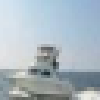

In [28]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

       bird        frog        ship         car


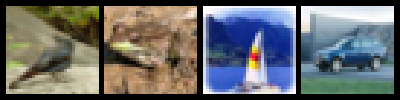

In [29]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## 新闻语料加载及预处理

# define net

## activative function

In [ ]:
# F.relu
# F.sigmoid
# F.tanh
# F.softplus

## simple net

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## complex net

In [ ]:
class Net_complex(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net_complex()
print(net)

# define loss function and optimizer

## loss function 

- 很多的 loss 函数都有 size_average 和 reduce 两个布尔类型的参数，需要解释一下。
- 因为一般损失函数都是直接计算 batch 的数据，因此返回的 loss 结果都是维度为 (batch_size, ) 的向量。
  - 如果 reduce = False，那么 size_average 参数失效，直接返回向量形式的 loss；
  - 如果 reduce = True (Default)，那么 loss 返回的是标量
     - 如果 size_average = True (Default)，返回 loss.mean();
     - 如果 size_average = False，返回 loss.sum();

### all

In [ ]:
# torch.nn.L1Loss(reduce=False, size_average=False) #  L1 损失
# torch.nn.SmoothL1Loss(reduce=False, size_average=False) # Huber Loss
# torch.nn.MSELoss(reduce=False, size_average=False) # 均方损失函数
# torch.nn.BCELoss(reduce=False, size_average=False) # 二分类用的交叉熵，用的时候需要在该层前面加上 Sigmoid 函数
# # loss = loss_fn(F.sigmoid(input), target)
# # nn.BCEWithLogitsLoss # nn.BCELoss 加一个 Sigmoid 层
# torch.nn.CrossEntropyLoss(reduce=False,   # 多分类用的交叉熵损失函数
#                           size_average=False, 
#                           weight=weight)
# nn.NLLLoss # 用于多分类的负对数似然损失函数
# nn.KLDivLoss # 相对熵，算的是两个分布之间的距离，越相似则越接近零
# nn.MarginRankingLoss # 评价相似度的损失

# nn.MultiMarginLoss # 多分类（multi-class）的 Hinge 损失
# nn.MultiLabelMarginLoss
# # 多类别（multi-class）多分类（multi-classification）的 Hinge 损失，是上面 MultiMarginLoss 在多类别上的拓展。
# nn.SoftMarginLoss # 多标签二分类问题
# nn.MultiLabelSoftMarginLoss # 多标签多分类版本

# nn.CosineEmbeddingLoss # 余弦相似度的损失，目的是让两个向量尽量相近
# nn.HingeEmbeddingLoss
# nn.TripleMarginLoss

# nn.PoissonNLLLoss  # 适合多目标分类

### common

In [34]:
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
# criterion = nn.MSELoss() # 均方损失函数

## optimizer

### all

### common

In [46]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [49]:
loss_f = nn.CrossEntropyLoss()
logstic = nn.Sequential(nn.Linear(2,4))
optimizer_l = optim.SGD(logstic.parameters(), lr=0.001)

# CPU 

In [50]:
start_time = time.time()
time_point, loss_point, accuracy_point = [], [], []

gpu_status = False
for t in range(2000):
    if gpu_status:
        train_x = Variable(x).cuda()
        train_y = Variable(y).cuda()
    else:
        train_x = Variable(x)
        train_y = Variable(y)
  # out = net(train_x)
    out_l = logstic(train_x)
    loss = loss_f(out_l,train_y)
    optimizer_l.zero_grad()
    loss.backward()
    optimizer_l.step()

In [52]:
if t % 10 == 0:
    prediction = torch.max(F.softmax(out_l, 1), 1)[1]
    pred_y = prediction.data
    accuracy = sum(pred_y ==train_y.data)/float(2000.0)
    loss_point.append(loss.data[0])
    accuracy_point.append(accuracy)
    time_point.append(time.time()-start_time)
    print("[{}/{}] | accuracy : {:.3f} | loss : {:.3f} | time : {:.2f} ".format(t + 1, 2000, 
                                                                                accuracy, 
                                                                                loss.data[0],
                                                                                time.time() - start_time))
    viz.line(X=np.column_stack((np.array(time_point),np.array(time_point))),
             Y=np.column_stack((np.array(loss_point),np.array(accuracy_point))),
             win=line,opts=dict(legend=["loss", "accuracy"]))
   #这里的数据如果用gpu跑会出错，要把数据换成cpu的数据 .cpu()即可
    viz.scatter(X=train_x.cpu().data, Y=pred_y.cpu()+1, win=scatter,name="add",
                opts=dict(markercolor=colors,legend=["0", "1", "2", "3"]))
    viz.text("<h3 align='center' style='color:blue'>accuracy : {}</h3><br><h3 align='center' style='color:pink'>"
               "loss : {:.4f}</h3><br><h3 align ='center' style='color:green'>time : {:.1f}</h3>"
               .format(accuracy,loss.data[0],time.time()-start_time),win =text)

## train

此处仅训练了2个epoch（遍历完一遍数据集称为一个epoch），来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label进行比较。

In [36]:
t.set_num_threads(8)
for epoch in range(2):      
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # 输入数据
        optimizer.zero_grad() # 梯度清零        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()                    
        optimizer.step() # 更新参数
        
        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.158
[1,  4000] loss: 1.840
[1,  6000] loss: 1.690
[1,  8000] loss: 1.558
[1, 10000] loss: 1.494
[1, 12000] loss: 1.458
[2,  2000] loss: 1.410
[2,  4000] loss: 1.370
[2,  6000] loss: 1.331
[2,  8000] loss: 1.319
[2, 10000] loss: 1.312
[2, 12000] loss: 1.308
Finished Training


实际的label:       cat     ship     ship    plane


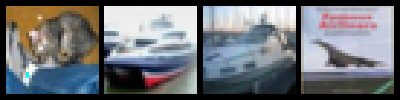

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [17]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:   bird   car  ship  ship


## visual result

### Tensorboard

### Visdom


In [42]:
viz = visdom.Visdom()
colors = np.random.randint(0,255,(4,3)) #颜色随机
#线图用来观察loss 和 accuracy
line = viz.line(X=np.arange(1,10,1), Y=np.arange(1,10,1))
#散点图用来观察分类变化
scatter = viz.scatter(X=x,Y=y+1, opts=dict(markercolor = colors,
                                           marksize = 5,
                                           legend=["0","1","2","3"]),)
#text 窗口用来显示loss 、accuracy 、时间
text = viz.text("FOR TEST")
#散点图做对比
viz.scatter(X=x,Y=y+1, opts=dict(markercolor = colors,
                                 marksize = 5,
                                 legend=["0","1","2","3"]),)

Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------
Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connection.py", line 137, in _new_conn
    (self.host, self.port), self.timeout, **extra_kw)
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 91, in create_connection
    raise err
  File "/usr/lib/python3/dist-packages/urllib3/util/connection.py", line 81, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 560, in urlopen
    body=body, headers=headers)
  File "/usr/lib/python3/dist-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/lib/python3.5/http/client.py", line 1106, in request
    self._send_request(method, url, body, headers)
  File "/usr/lib/python3.5/http/client.py", line 11

False

## test

In [18]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 53 %


## save model

# GPU

## train

In [23]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

RuntimeError: Expected object of type torch.cuda.FloatTensor but found type torch.cuda.LongTensor for argument #2 'target'

In [ ]:
use_gpu = True